# 06 Evaluate & Interpret

## 0 Imports & global paths

In [ ]:
# ===== 0 Imports & Global Paths =========================================
from pathlib import Path
import json                                              # metrics persistence
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    ConfusionMatrixDisplay,
)
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForSequenceClassification

PROJ_ROOT = Path.cwd().parent                       #  …/twitter‑airline‑analysis
MODEL_DIR = PROJ_ROOT / "models" / "distilbert_twitter" / "final"
TOKEN_DIR = MODEL_DIR / "tokenizer"

DATA_DIR = PROJ_ROOT / "data" / "processed"
REPORTS_DIR = PROJ_ROOT / "reports"
REPORTS_DIR.mkdir(exist_ok=True)

tok   = AutoTokenizer.from_pretrained(TOKEN_DIR,  local_files_only=True)
model = AutoModelForSequenceClassification.from_pretrained(
            MODEL_DIR, local_files_only=True).eval()

print(model.config.id2label)      # {0:'negative',1:'neutral',2:'positive'}


{0: 'negative', 1: 'neutral', 2: 'positive'}


In [5]:
print(PROJ_ROOT)

c:\Projects\twitter-airline-analysis\notebooks


## 1 Load validation & test splits

In [8]:
# ===== 1 Load Validation / Test Splits ==================================
X_val  = pd.read_feather(DATA_DIR / "X_val.ftr")["clean_text"]
y_val  = pd.read_feather(DATA_DIR / "y_val.ftr")["airline_sentiment"]

X_test = pd.read_feather(DATA_DIR / "X_test.ftr")["clean_text"]
y_test = pd.read_feather(DATA_DIR / "y_test.ftr")["airline_sentiment"]

print(f"val rows: {len(X_val):,} | test rows: {len(X_test):,}")

KeyError: 'clean_text'

## 2 Load fine‑tuned model

In [ ]:
# ===== 2 Load Fine‑Tuned Model ==========================================
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR, local_files_only=True)
model     = AutoModelForSequenceClassification.from_pretrained(
               MODEL_DIR, local_files_only=True
           ).eval()

label_map   = model.config.id2label
num_labels  = len(label_map)
label_map

{0: 'negative', 1: 'neutral', 2: 'positive'}

## 3 Predict & evaluate

In [ ]:
# ===== 3 a Predict & collect metrics ====================================
import torch
from torch.utils.data import DataLoader

def _predict(texts, batch_size: int = 64):
    if isinstance(texts, pd.Series):        
        texts = texts.tolist()              

    loader = DataLoader(texts, batch_size=batch_size)
    preds, probs = [], []

    for batch in loader:
        enc = tokenizer(batch, padding=True, truncation=True, return_tensors="pt")
        with torch.no_grad():
            out = model(**enc)
            p   = out.logits.softmax(dim=1)

        preds.extend(p.argmax(dim=1).cpu().tolist())
        probs.extend(p.cpu().tolist())

    return preds, probs


y_val_pred,  y_val_prob  = _predict(X_val)
y_test_pred, y_test_prob = _predict(X_test)

metrics = {
    "val": {
        "accuracy":  accuracy_score(y_val,  y_val_pred),
        "macro_f1":  precision_recall_fscore_support(y_val, y_val_pred, average="macro")[2],
    },
    "test": {
        "accuracy":  accuracy_score(y_test, y_test_pred),
        "macro_f1":  precision_recall_fscore_support(y_test, y_test_pred, average="macro")[2],
    },
}
metrics

c:\Users\justi\Anaconda3\envs\twitter-sentiment-env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\justi\Anaconda3\envs\twitter-sentiment-env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'val': {'accuracy': 0.7837954939341422, 'macro_f1': 0.3799669331585656},
 'test': {'accuracy': 0.7717626678215678, 'macro_f1': 0.3656768837803321}}

In [ ]:
print(y_val.value_counts(), "\n")
print(y_test.value_counts())

label
0    1836
1     472
Name: count, dtype: int64 

label
0    1836
1     473
Name: count, dtype: int64


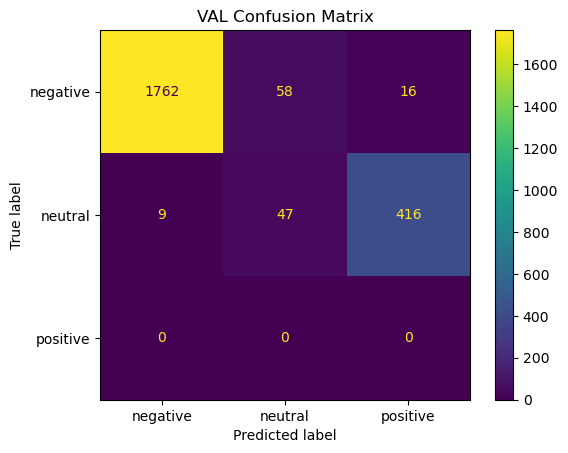

<Figure size 640x480 with 0 Axes>

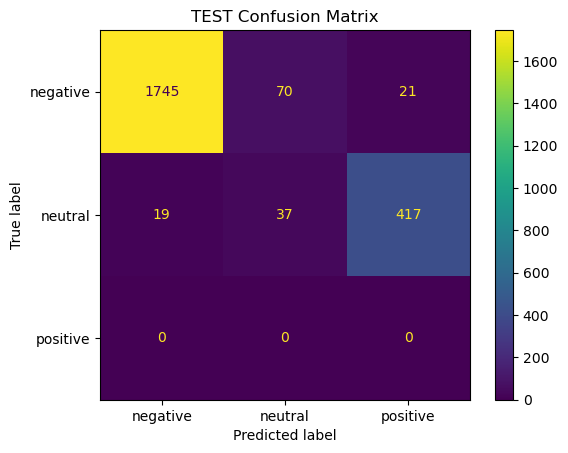

<Figure size 640x480 with 0 Axes>

In [ ]:
# ===== 3 b ROC, PR & Confusion‑Matrix ===================================
fig_dir = REPORTS_DIR / "figs_06"
fig_dir.mkdir(exist_ok=True)

# ROC + PR need probabilities for *positive* class (assume id 1)
pos_idx = 1 if num_labels == 2 else None

for split, y_true, y_prob, y_hat in [
    ("val",  y_val,  y_val_prob,  y_val_pred),
    ("test", y_test, y_test_prob, y_test_pred),
]:
    # ROC
    if num_labels == 2:
        RocCurveDisplay.from_predictions(
            y_true, [p[pos_idx] for p in y_prob], name=f"{split.upper()} ROC"
        )
        plt.savefig(fig_dir / f"roc_{split}.png", dpi=150)
        plt.show()
        plt.clf()

        PrecisionRecallDisplay.from_predictions(
            y_true, [p[pos_idx] for p in y_prob], name=f"{split.upper()} PR"
        )
        plt.savefig(fig_dir / f"pr_{split}.png", dpi=150)
        plt.show()
        plt.clf()

    # Confusion matrix
    ConfusionMatrixDisplay.from_predictions(y_true, y_hat, display_labels=list(label_map.values()))
    plt.title(f"{split.upper()} Confusion Matrix")
    plt.savefig(fig_dir / f"cm_{split}.png", dpi=150)
    plt.show()
    plt.clf()


## 4 Save metrics & artefacts

In [ ]:
# ===== 4 Persist Metrics & Model Card ===================================
# 4 a  simple CSV / JSON
(pd.DataFrame.from_dict(metrics, orient="index")
   .to_csv(REPORTS_DIR / "metrics_module_5.csv"))

with open(REPORTS_DIR / "metrics_module_5.json", "w") as fp:
    json.dump(metrics, fp, indent=2)

# 4 b  (Optionally) save a tiny model‑card stub alongside the weights
card = {
    "model_name": "bert_twitter",
    "num_labels": num_labels,
    "metrics": metrics["val"],
}
with open(MODEL_DIR / "model_card.json", "w") as fp:
    json.dump(card, fp, indent=2)

print("✓ Artefacts written to", REPORTS_DIR.resolve())


✓ Artefacts written to C:\Projects\twitter-airline-analysis\reports


## 5 SHAP explainability

In [ ]:
# ===== 5 Optional: SHAP KernelExplainer ==================================
# NOTE: Slow—only run if you actually need SHAP plots.
import shap 
import numpy as np

explainer = shap.Explainer(lambda txt: np.array(_predict(txt)[1]), tokenizer)
shap_values = explainer(X_val[:100])

shap.plots.text(shap_values[0])  # shows an interactive HTML in Jupyter

PartitionExplainer explainer: 101it [08:33,  5.13s/it]                         


In [ ]:
from pathlib import Path 
list((Path("../models/distilbert_twitter/final")).iterdir())

ImportError: cannot import name 'pprint' from 'pathlib' (c:\Users\justi\Anaconda3\envs\twitter-sentiment-env\Lib\pathlib.py)

In [ ]:
print(MODEL_DIR) 

C:\Projects\twitter-airline-analysis\models\distilbert_twitter\final
